### CRYPTO MEAN REVERSION PAIRS TRADING WITH INCLUSION OF A KALMAN FILTER

In this notebook we are going look at the concept of building a trading strategy backtest based on mean reverting, co-integrated pairs of crypto currencies. So to restate the theory in in terms of US equities, stocks that are statistically co-integrated move in a way that means when their prices start to diverge by a certain amount (i.e. the spread between the 2 stocks prices increases), we would expect that divergence to
eventually revert back to the mean. In this instance we would look to sell the outperforming stock,and buy the under performing stock in our expectance that the under performing stock would eventually “catch up” with the overpeforming stock and rise in price, or vice versa the overperforming stock would in time suffer from the same downward pressure of the underperforming stock and fall in relative value.

Hence, pairs trading is a market neutral trading strategy enabling traders to profit from virtually any market conditions: Bull Market, Bear Market, or Sideways Market.

So in our search for co-integrated Altcoins, economic theory would suggest that we are more likley to find pairs of that are driven by the same factors, if we search for pairs that are drawn from similar/the same blockchain & technology. After all, it is logical to expect
2 Altcoins with similar blockchain tech and use case could be considered similar products, to be at the mercy of the same general ups and downs of the volatile crypto market.

### Kalman Filter

So what is a Kalman Filter? Well this site (http://www.bzarg.com/p/how-a-kalman-filter-works-in-pictures/) explains and states the following:

You can use a Kalman filter in any place where you have uncertain information about some dynamic system, and you can make an educated guess about what the system is going to do next. Even if messy reality comes along and interferes with the clean motion you guessed about, the Kalman filter will often do a very good job of figuring out what actually happened. And it can take advantage of correlations between crazy phenomena that you maybe wouldn’t have thought to exploit!

Kalman filters are ideal for systems which are continuously changing. They have the advantage that they are light on memory (they don’t need to keep any history other than the previous state), and they are very fast, making them well suited for real time problems and embedded systems.

So lets start to import the relevant modules we will need for our strategy backtest:

In [453]:
from time import time
import numpy as np                  
import matplotlib.pyplot as plt   
import datetime as dt  
import pandas as pd
import math
import os.path
import time
import json
import requests
from bitmex import bitmex
from binance.client import Client
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm_notebook 
import seaborn as sns
import matplotlib as mpl
mpl.style.use('seaborn')
import statsmodels.api as sm
from pykalman import KalmanFilter
from math import sqrt
import warnings
warnings.filterwarnings('ignore')
import ffn

In [454]:
### CONSTANTS
binsizes = {"1m": 1, "5m": 5, "1h": 60, "4h": 240, "8h": 480, "12h": 720, "1d": 1440}
batch_size = 750
binance_client = Client(api_key=binance_api_key, api_secret=binance_api_secret)

In [455]:
### FUNCTIONS
def minutes_of_new_data(symbol, kline_size, data, source):
    if len(data) > 0:  old = parser.parse(data["timestamp"].iloc[-1])
    elif source == "binance": old = datetime.strptime('30 Nov 2017', '%d %b %Y')
    if source == "binance": new = pd.to_datetime(binance_client.get_klines(symbol=symbol, interval=kline_size)[-1][0], unit='ms')
    return old, new

## Get Historical Pricing from Binance 
def get_all_binance(symbol, kline_size, save = False):
    filename = 'Binance_%s_%s_data.csv' % (symbol, kline_size)
    if os.path.isfile(filename): data_df = pd.read_csv(filename)
    else: data_df = pd.DataFrame()
    oldest_point, newest_point = minutes_of_new_data(symbol, kline_size, data_df, source = "binance")
    delta_min = (newest_point - oldest_point).total_seconds()/60
    available_data = math.ceil(delta_min/binsizes[kline_size])
    if oldest_point == datetime.strptime('30 Nov 2017', '%d %b %Y'): print('Downloading all available %s data for %s. Be patient..!' % (kline_size, symbol))
    else: print('Downloading %d minutes of new data available for %s, i.e. %d instances of %s data.' % (delta_min, symbol, available_data, kline_size))
    klines = binance_client.get_historical_klines(symbol, kline_size, oldest_point.strftime("%d %b %Y %H:%M:%S"), newest_point.strftime("%d %b %Y %H:%M:%S"))
    data = pd.DataFrame(klines, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])
    data = data.drop('ignore', axis=1)
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
    if len(data_df) > 0:
        temp_df = pd.DataFrame(data)
        data_df = data_df.append(temp_df)
    else: data_df = data
    data_df.set_index('timestamp', inplace=True)
    print('All caught up..!')
    return data_df

In [456]:
# For all Binance USDT symbols
# https://steemit.com/money/@marketstack/visualizing-alt-coin-correlation
symbols = json.loads(requests.get("https://api.binance.com/api/v1/exchangeInfo").text)
symbols = [symbol['symbol'] for symbol in symbols['symbols'] if symbol['quoteAsset'] == 'BTC']

What we're left with here is a list of any pair with BTC as the quote side of the pair. We will combine this data with the price history of BTC/USDT to create time series for each cryptocurrency quoted in USDT instead of BTC.

To do this we'll use our get_bars function to retrieve the data for BTC/USDT

In [457]:
btcusdt = get_all_binance('BTCUSDT', '8h', save = False)

All caught up..!


In [437]:
# Downloading all Altcoin price data
price_data = []
new_symbols = []
binance_symbols = symbols
for symbol in binance_symbols:
    data = get_all_binance(symbol, '8h', save = False)
    new_symbols.append(symbol.replace('BTC','USDT')) 
    price_data.append(data['close'].astype('float') * btcusdt['close'].astype('float'))

All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up.

All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up.

In [458]:
# Merge all price data into a single dataframe and drop all NaNs
combo = pd.concat(price_data, axis = 1)
combo.columns = new_symbols
combo = combo.dropna(axis=1, how='any', thresh=None, subset=None, inplace=False)
combo.head()

,ETHUSDT,LTCUSDT,BNBUSDT,NEOUSDT,GASUSDT,MCOUSDT,WTCUSDT,LRCUSDT,QTUMUSDT,YOYOUSDT,...,QSPUSDT,BTSUSDT,XZCUSDT,LSKUSDT,TNTUSDT,FUELUSDT,MANAUSDT,BCDUSDT,DGDUSDT,ADXUSDT
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-11-30 00:00:00,434.298960,85.967590,1.879968,32.757710,19.193420,5.961440,5.186654,0.193646,12.053790,0.073511,...,0.118020,0.136046,35.970040,7.153728,0.073712,0.037763,0.015508,51.77994,117.738440,1.095817
2017-11-30 08:00:00,392.219460,75.153620,1.785134,29.400520,16.451360,5.037780,5.001860,0.169722,10.946620,0.071840,...,0.097972,0.119434,31.573680,6.555400,0.066991,0.037267,0.013380,47.59400,87.869300,0.978820
2017-11-30 16:00:00,429.480443,85.412012,1.967792,32.557119,18.595634,5.696758,6.670421,0.203273,11.875625,0.087567,...,0.118166,0.131645,35.420256,7.408737,0.073202,0.038470,0.015152,50.61161,98.556862,1.082384
2017-12-01 00:00:00,419.387940,82.358820,1.962092,33.962400,18.469440,5.609520,6.410594,0.208449,11.495700,0.089962,...,0.108565,0.131652,34.906860,7.216056,0.073076,0.040068,0.014501,49.53168,96.287220,1.066667
2017-12-01 08:00:00,446.401420,91.211200,2.030391,34.905020,18.838460,5.993580,7.149724,0.210664,12.196360,0.092676,...,0.118616,0.140164,37.300360,7.638938,0.076149,0.042572,0.015481,54.82086,102.738120,1.202795


Plot the resulting DataFrame of price data just to make sure we have what we need and as a quick sanity check:

In [439]:
num_coins = len(combo.columns)
print('Number of Altcoins =', num_coins) 

Number of Altcoins = 68


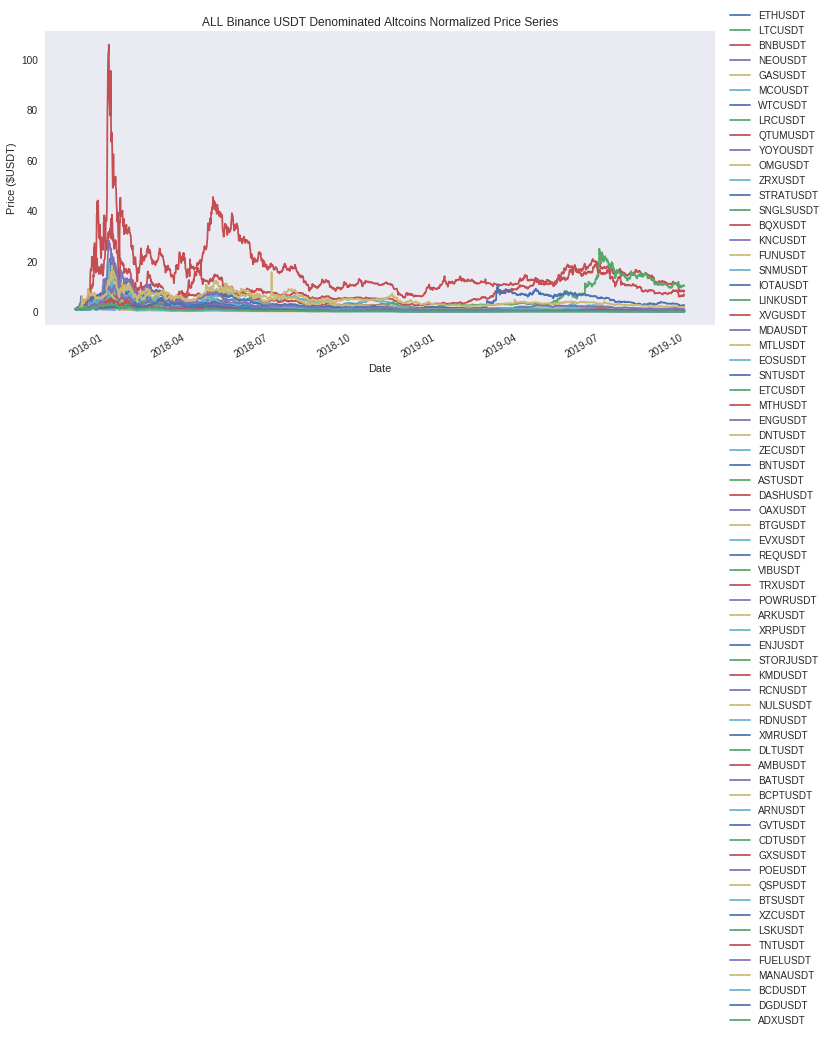

In [440]:
combo.div(combo.iloc[0,:]).plot(figsize=(12, 6))# Normalize Prices 
plt.title('ALL Binance USDT Denominated Altcoins Normalized Price Series')
plt.xlabel('Date')
plt.ylabel('Price ($USDT)')
plt.grid(b=None, which=u'major', axis=u'both')
plt.legend(bbox_to_anchor=(1.01, 1.1), loc='upper left', ncol=1)
plt.show();

Ok so it looks from the chart as if we have around price data downloaded for 69 Altcoins; this should be more than enough to find at least a couple of co-integrated pairs to run our backtest over.

We will now define a quick function that will run our Altcoins, combining them into pairs one by one and running co-integration tests on each pair. That result will then be stored in a matrix that we initialise,
and then we will be able to plot that matrix as a heatmap. Also, if the co-integration test meets our threshold statistical significance (in our case 5%), then that pair of Altcoin tickers will be stored in a list for later retrieval.

In [441]:
# Source: https://pythonforfinance.net/2018/07/04/mean-reversion-pairs-trading-with-inclusion-of-a-kalman-filter/
# NOTE CRITICAL LEVEL HAS BEEN SET TO 5% FOR COINTEGRATION TEST
def find_cointegrated_pairs(dataframe, critial_level = 0.05):
    n = dataframe.shape[1] # the length of dateframe
    pvalue_matrix = np.ones((n, n)) # initialize the matrix of p
    keys = dataframe.columns # get the column names
    pairs = [] # initilize the list for cointegration
    for i in range(n):
        for j in range(i+1, n): # for j bigger than i
            stock1 = dataframe[keys[i]] # obtain the price of "stock1"
            stock2 = dataframe[keys[j]]# obtain the price of "stock2"
            result = sm.tsa.stattools.coint(stock1, stock2) # get conintegration
            pvalue = result[1] # get the pvalue
            pvalue_matrix[i, j] = pvalue
            if pvalue < critial_level: # if p-value less than the critical level
                pairs.append((keys[i], keys[j], pvalue)) # record the contract with that p-value
    return pvalue_matrix, pairs

Let’s now run our data through our function, save the results and plot the heatmap:

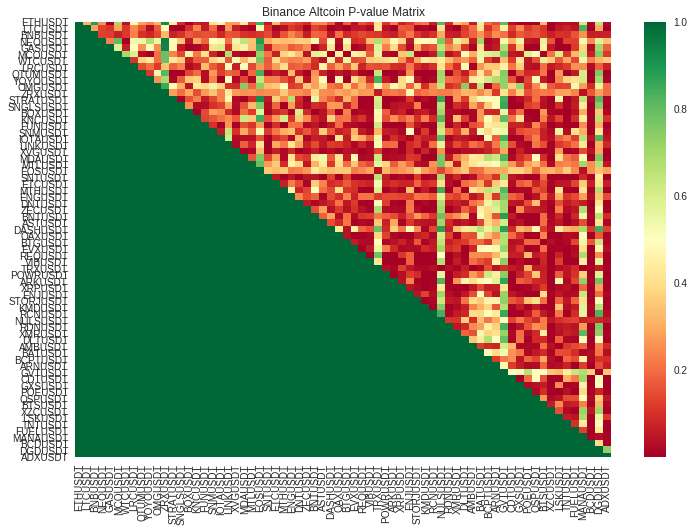

In [442]:
df = combo

binance_symbols = df.columns

# Set up the split point for our "training data" on which to perform the co-integration test (the remaining dat awill be fed to our backtest function)
split = int(len(df) * 0.4)

# Run our dataframe (up to the split point) of ticker price data through our co-integration function and store results
pvalue_matrix,pairs = find_cointegrated_pairs(df[:split])

# Convert our matrix of stored results into a DataFrame
pvalue_matrix_df = pd.DataFrame(pvalue_matrix)

# Use Seaborn to plot a heatmap of our results matrix
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(pvalue_matrix_df,xticklabels=binance_symbols,yticklabels=binance_symbols,ax=ax,cmap="RdYlGn")
plt.title('Binance Altcoin P-value Matrix')
plt.show();

So we can see from the very dark red squares that it looks as though there are indeed a few pairs of Altcoins who’s co-integration score is below the 5% threshold
hardcoded into the function we defined. To see more explicitly which pairs these are, let’s print out our list of stored pairs that was part of the fucntion results we stored:

In [443]:
for pair in pairs:
    print("Altcoin {} and Altcoin {} has a co-integration score of {}".format(pair[0],pair[1],round(pair[2],4)))

Altcoin ETHUSDT and Altcoin GASUSDT has a co-integration score of 0.0073
Altcoin ETHUSDT and Altcoin WTCUSDT has a co-integration score of 0.039
Altcoin ETHUSDT and Altcoin BQXUSDT has a co-integration score of 0.0039
Altcoin ETHUSDT and Altcoin FUNUSDT has a co-integration score of 0.0496
Altcoin ETHUSDT and Altcoin OAXUSDT has a co-integration score of 0.0179
Altcoin ETHUSDT and Altcoin EVXUSDT has a co-integration score of 0.0427
Altcoin ETHUSDT and Altcoin CDTUSDT has a co-integration score of 0.0387
Altcoin ETHUSDT and Altcoin GXSUSDT has a co-integration score of 0.0066
Altcoin ETHUSDT and Altcoin POEUSDT has a co-integration score of 0.0025
Altcoin ETHUSDT and Altcoin QSPUSDT has a co-integration score of 0.0024
Altcoin ETHUSDT and Altcoin XZCUSDT has a co-integration score of 0.0064
Altcoin ETHUSDT and Altcoin LSKUSDT has a co-integration score of 0.0276
Altcoin ETHUSDT and Altcoin TNTUSDT has a co-integration score of 0.0364
Altcoin ETHUSDT and Altcoin FUELUSDT has a co-integr

We will now use the “pykalman” module to set up a couple of functions that will allow us to generate Kalman filters which we will apply to our data and in turn our regression that is fed the said data.

In [444]:
def KalmanFilterAverage(x):
  # Construct a Kalman filter
    kf = KalmanFilter(transition_matrices = [1],
    observation_matrices = [1],
    initial_state_mean = 0,
    initial_state_covariance = 1,
    observation_covariance=1,
    transition_covariance=.01)
  # Use the observed values of the price to get a rolling mean
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means

# Kalman filter regression
def KalmanFilterRegression(x,y):
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)
    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
    initial_state_mean=[0,0],
    initial_state_covariance=np.ones((2, 2)),
    transition_matrices=np.eye(2),
    observation_matrices=obs_mat,
    observation_covariance=2,
    transition_covariance=trans_cov)
    # Use the observations y to get running estimates and errors for the state parameters
    state_means, state_covs = kf.filter(y.values)
    return state_means

def half_life(spread):
    spread_lag = spread.shift(1)
    spread_lag.iloc[0] = spread_lag.iloc[1]
    spread_ret = spread - spread_lag
    spread_ret.iloc[0] = spread_ret.iloc[1]
    spread_lag2 = sm.add_constant(spread_lag)
    model = sm.OLS(spread_ret,spread_lag2)
    res = model.fit()
    halflife = int(round(-np.log(2) / res.params[1],0))
    if halflife <= 0:
        halflife = 1
    return halflife

Now let us define our main “Backtest” function that we will run our data through. The fucntion takes one pair of tickers at a time, and then returns several outputs, namely the DataFrame of cumulative returns,
the Sharpe Ratio and the Compound Annual Growth Rate (CAGR). Once we have defined our function, we can iterate over our list of pairs and feed the relevant data, pair by pair, into the function, storing the outputs for each pair for
later use and retrieval.

In [467]:
def backtest(df,s1, s2):
    #############################################################
    # INPUT:
    # DataFrame of prices
    # s1: the symbol of contract one
    # s2: the symbol of contract two
    # x: the price series of contract one
    # y: the price series of contract two
    # OUTPUT:
    # df1['cum rets']: cumulative returns in pandas data frame
    # sharpe: Sharpe ratio
    # CAGR: Compound Annual Growth Rate
    x = df[s1]
    y = df[s2]
    
    # run regression (including Kalman Filter) to find hedge ratio and then create spread series
    df1 = pd.DataFrame({'y':y,'x':x})
    df1.index = pd.to_datetime(df1.index)
    state_means = KalmanFilterRegression(KalmanFilterAverage(x),KalmanFilterAverage(y))
    df1['hr'] = - state_means[:,0]
    df1['spread'] = df1.y + (df1.x * df1.hr)
    
    # calculate half life
    halflife = half_life(df1['spread'])
    
    # calculate z-score with window = half life period
    meanSpread = df1.spread.rolling(window=halflife).mean()
    stdSpread = df1.spread.rolling(window=halflife).std()
    df1['zScore'] = (df1.spread-meanSpread)/stdSpread
    
    ##############################################################
    
    # trading logic
    entryZscore = 1.25
    exitZscore = 0
    
    #set up num units long
    df1['long entry'] = ((df1.zScore < - entryZscore) & ( df1.zScore.shift(1) > - entryZscore))
    df1['long exit'] = ((df1.zScore > - exitZscore) & (df1.zScore.shift(1) < - exitZscore))
    df1['num units long'] = np.nan 
    df1.loc[df1['long entry'],'num units long'] = 1 
    df1.loc[df1['long exit'],'num units long'] = 0 
    df1['num units long'][0] = 0 
    df1['num units long'] = df1['num units long'].fillna(method='pad')
    
    #set up num units short 
    df1['short entry'] = ((df1.zScore > entryZscore) & ( df1.zScore.shift(1) < entryZscore))
    df1['short exit'] = ((df1.zScore < exitZscore) & (df1.zScore.shift(1) > exitZscore))
    df1.loc[df1['short entry'],'num units short'] = -1
    df1.loc[df1['short exit'],'num units short'] = 0
    df1['num units short'][0] = 0
    df1['num units short'] = df1['num units short'].fillna(method='pad')
    df1['numUnits'] = df1['num units long'] + df1['num units short']
    df1['spread pct ch'] = (df1['spread'] - df1['spread'].shift(1)) / ((df1['x'] * abs(df1['hr'])) + df1['y'])
    df1['port rets'] = df1['spread pct ch'] * df1['numUnits'].shift(1)
    df1['cum rets'] = df1['port rets'].cumsum()
    df1['cum rets'] = df1['cum rets'] + 1

    ##############################################################
    
    try:
        sharpe = ((df1['port rets'].mean() / df1['port rets'].std()) * sqrt(252))
    except ZeroDivisionError:
        sharpe = 0.0
        
    ##############################################################
    
    start_val = 1
    end_val = df1['cum rets'].iat[-1]
    start_date = df1.iloc[0].name
    end_date = df1.iloc[-1].name
    days = (end_date - start_date).days
    CAGR = (end_val / start_val) ** (252.0/days) - 1
    #CAGR = round(((float(end_val) / float(start_val)) ** (252.0/days)) - 1,4)
    df1[s1+ " "+s2] = df1['cum rets']
    return df1[s1+" "+s2], sharpe, CAGR

So now let’s run our full list of pairs through our Backtest function, and print out some results along the way, and finally after storing the equity curve for each pair,
produce a chart that plots out each curve.

The pair ETHUSDT and WTCUSDT produced a Sharpe Ratio of 1.4 and a CAGR of 0.6687
The pair ETHUSDT and OAXUSDT produced a Sharpe Ratio of 0.0 and a CAGR of 0.0
The pair ETHUSDT and CDTUSDT produced a Sharpe Ratio of 1.83 and a CAGR of 1.0438
The pair ETHUSDT and XZCUSDT produced a Sharpe Ratio of 1.52 and a CAGR of 0.6497
The pair ETHUSDT and FUELUSDT produced a Sharpe Ratio of 2.66 and a CAGR of 1.3174
The pair ETHUSDT and ADXUSDT produced a Sharpe Ratio of 0.0 and a CAGR of 0.0
The pair LTCUSDT and OAXUSDT produced a Sharpe Ratio of 1.34 and a CAGR of 1.0304
The pair NEOUSDT and OAXUSDT produced a Sharpe Ratio of 0.61 and a CAGR of 0.6197
The pair GASUSDT and KNCUSDT produced a Sharpe Ratio of 0.8 and a CAGR of 0.5687
The pair GASUSDT and OAXUSDT produced a Sharpe Ratio of 0.86 and a CAGR of 0.9026
The pair GASUSDT and EVXUSDT produced a Sharpe Ratio of 1.03 and a CAGR of 1.0372
The pair GASUSDT and AMBUSDT produced a Sharpe Ratio of 0.99 and a CAGR of 0.6606
The pair GASUSDT and QSPU

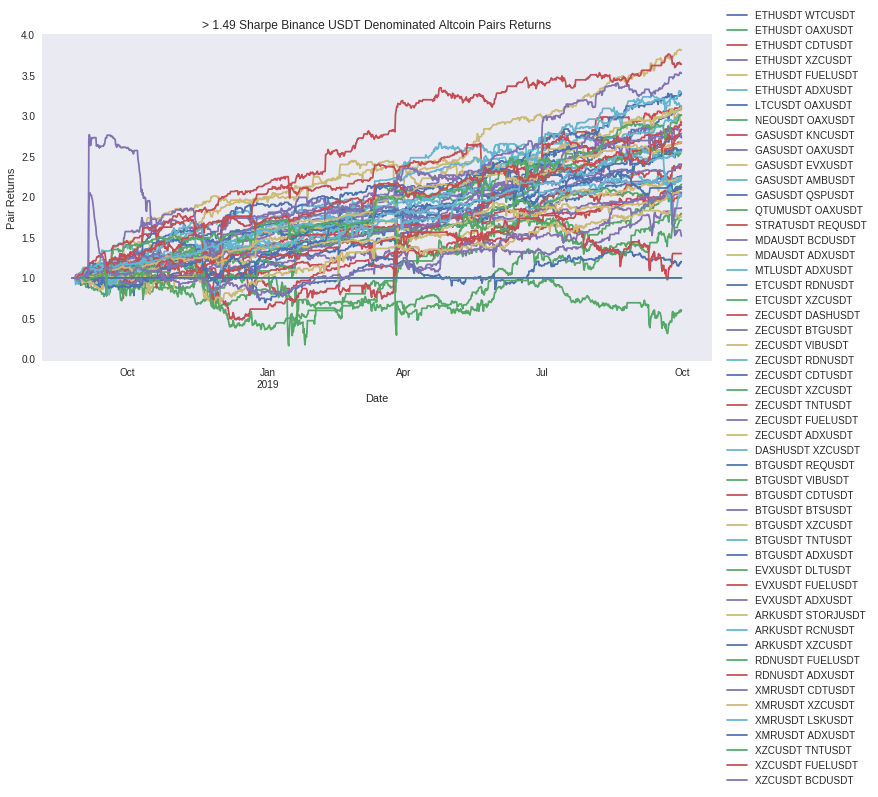

In [468]:
results = []
for pair in pairs:
    rets, sharpe,  CAGR = backtest(df[split:],pair[0],pair[1])
    rets2, sharpe2,  CAGR2 = backtest(df[:split],pair[0],pair[1])
    if round(sharpe2,2) > 1.49:
        results.append(rets)
        print("The pair {} and {} produced a Sharpe Ratio of {} and a CAGR of {}".format(pair[0],pair[1],round(sharpe,2),round(CAGR,4)))
        #print("The pair {} and {} produced a Sharpe Ratio of {} and a CAGR of {}".format(pair[0],pair[1],round(sharpe,2),round(CAGR,4)))
        rets.plot(figsize=(12,6),legend=True)
        plt.legend(bbox_to_anchor=(1.01, 1.1), loc='upper left', ncol=1)
        plt.grid(b=None, which=u'major', axis=u'both')
        plt.title('> 1.49 Sharpe Binance USDT Denominated Altcoin Pairs Returns')
        plt.xlabel('Date')
        plt.ylabel('Pair Returns');

Now we run a few extra lines of code to combine, equally weight, and print our our final equity curve:

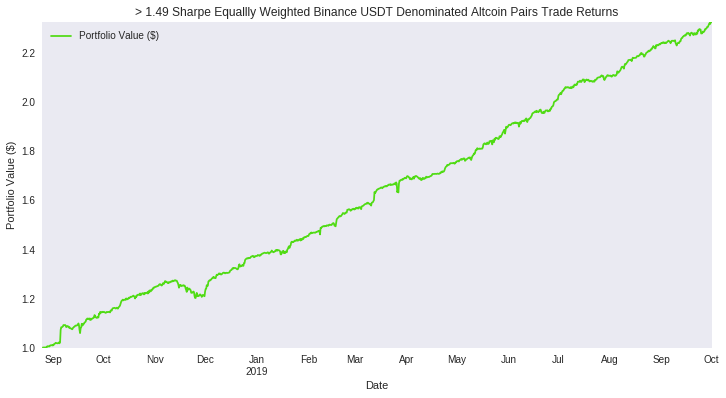

In [470]:
#concatenate together the individual equity curves into a single DataFrame
results_df = pd.concat(results,axis=1).dropna()

#equally weight each equity curve by dividing each by the number of pairs held in the DataFrame
results_df /= len(results_df.columns)

#sum up the equally weighted equity curves to get our final equity curve
final_res = results_df.sum(axis=1)

#plot the chart of our final equity curve
final_res.plot(label='Portfolio Value ($)',color='#50db14', figsize=(12,6))
plt.title('> 1.49 Sharpe Equallly Weighted Binance USDT Denominated Altcoin Pairs Trade Returns')
plt.margins(0.001)
plt.grid(b=None, which=u'major', axis=u'both')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend();

### Underwater Plot

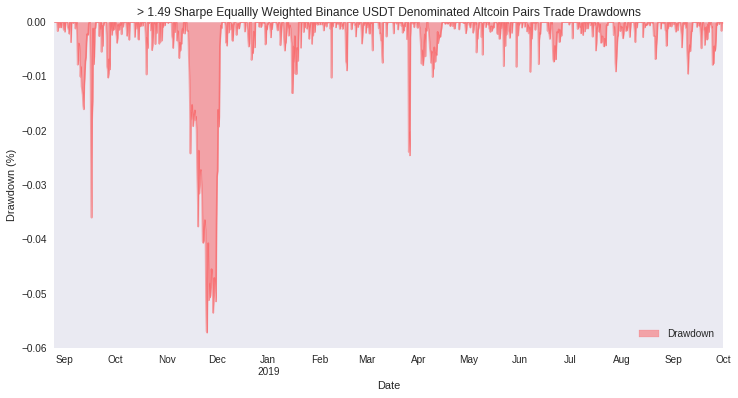

In [477]:
ffn.to_drawdown_series(final_res).plot(kind = 'area',alpha=.4,label='Drawdown',color='#ff3838',figsize=(12,6),grid=False)
plt.title('> 1.49 Sharpe Equallly Weighted Binance USDT Denominated Altcoin Pairs Trade Drawdowns')
plt.margins(0.001)
plt.xlabel('Date')
plt.ylabel('Drawdown (%)')
plt.legend(loc='lower right');

In [471]:
num_coins = len(results_df.columns)
print('Number of Pairs =', num_coins)

Number of Pairs = 52


### Total Returns Performance

In [473]:
perf = final_res.calc_stats()
perf.display()

Stats for None from 2018-08-25 16:00:00 - 2019-09-30 16:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR     Max Drawdown
--------------  --------  -------  --------------
132.48%             5.93  115.64%  -5.02%

Annualized Returns:
mtd    3m      6m      ytd     1y       3y       5y    10y    incep.
-----  ------  ------  ------  -------  -------  ----  -----  --------
3.74%  15.64%  37.46%  69.32%  103.22%  115.64%  -     -      115.64%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  5.93     5.50       -
mean    53.47%   80.35%     69.32%
vol     9.02%    14.60%     -
skew    3.47     -0.43      -
kurt    37.92    1.65       -
best    6.43%    13.58%     69.32%
worst   -2.01%   -2.92%     69.32%

Drawdowns:
max     avg       # days
------  ------  --------
-5.02%  -0.46%      2.39

Misc:
---------------  -------
avg. up month    7.50%
avg. down month  -2.92%
up year %        100.00%
12m up %         10

### Monthly Returns Performance

In [474]:
perf.display_monthly_returns()

  Year    Jan    Feb    Mar    Apr    May    Jun    Jul    Aug    Sep    Oct    Nov    Dec    YTD
------  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----
  2018   0      0      0      0      0      0      0      1.06  13.2    8.85  -2.92  13.58  37.31
  2019   5.96   7.38   8.14   3.86   8.22   5.86   4.84   6.32   3.74   0      0      0     69.32


In [475]:
perf.stats

start                    2018-08-25 16:00:00
end                      2019-09-30 16:00:00
rf                                         0
total_return                         1.32483
cagr                                 1.15639
max_drawdown                      -0.0502356
calmar                               23.0192
mtd                                0.0374225
three_month                         0.156442
six_month                            0.37459
ytd                                 0.693185
one_year                              1.0322
three_year                           1.15639
five_year                                NaN
ten_year                                 NaN
incep                                1.15639
daily_sharpe                         5.92648
daily_sortino                        14.5353
daily_mean                          0.534731
daily_vol                          0.0902275
daily_skew                           3.46647
daily_kurt                           37.9245
best_day  

The Sharpe Ratio is very good. Also take into consideration trading cost for crypto currency is very minimal but was not factored in these performance stats. The testing period was only from August 2018 until September 29th 2019 only looking at specific pairs returns when traded in the training period that was able to yield a greater than 1.49 sharpe ratio on 8hr closing prices. Then creating an equal weight portfolio of those high yielding sharpe pairs to trade in the test period. Cummulative returns were almost 82% for about 1yr with decent drawdown (fucking impressive). 